# Парсер HeadHunter
 чтобы получать  вакансии, которые интересны мне



### Импорт библиотек

In [1]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import time

from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 30)

In [2]:
#!pip freeze

In [3]:
import pathlib
from pathlib import Path

### Делаем выгрузку из HeadHunter
Ссылка на API: https://github.com/hhru/api \
Для того, чтобы написать запрос используется язык поисковых запросов, задокументированный тут: https://hh.ru/article/1175 \
Фильтрацию можно делать в самом запросе, например, сделать поиск по полю компаний или же по наличию конкретного текста в описании, где COMPANY_NAME - название компании, а DESCRIPTION - описание вакансии. Причем интересно, что этот язык запросов работает и на обычном сайте hh.ru, что бывает иногда полезно

Создадим необходимые константы: BASE_URL

In [4]:
# Задам кол-во дней для определения периода поиска опубликования вакансии
day_vacs=7

In [5]:
# Для запросов формируем их и дату
BASE_URL = "https://api.hh.ru/"
TEXT = f'NAME:("Machine Learning Engineer" OR "Data Scientist" OR "Дата саентист" OR "Machine Learning Developer" or "Machine Learning Researcher" or "Искусственный интеллект" or "Машинное обучение" or "Специалист по machine learning" or "Специалист по машинному обучению" or "AI engineer" or "Разработчик ML" or "Data Science" or "Machine Learning" or "Artificial Intelligence" or "ML Engineer" or "Аналитик" or "Analyst" or "Data Engineer" or "DWH" or "BI" or "Business Intelligence" or "Data инженер" or "Инженер данных" or "ETL" or "КХД")'
dt_now = datetime.now().date()
dt_from = dt_now - timedelta(days=day_vacs)
DATE_TO = '%s-%02d-%02d' % (dt_now.year, dt_now.month, dt_now.day)
DATE_FROM = '%s-%02d-%02d' % (dt_from.year, dt_from.month, dt_from.day)

VAC_URL = BASE_URL + f'vacancies?text={TEXT}&date_from={DATE_FROM}&date_to={DATE_TO}&responses_count_enabled=True&per_page=100'

In [6]:
DATE_FROM

'2022-03-31'

In [7]:
#Создали пустую таблицу
vacancy_df = pd.DataFrame()


В выдаче апи hh нет опыта, поэтому укажем его в запросе:\
Важно помнить, что можно откликаться на вакансии с "от 1 года опыта" :)

In [8]:
experiences = ['noExperience', # без опыта
               'between1And3',# опыт до 3 лет
              # 'between3And6', 
              # 'moreThan6'
              ]

In [9]:
for exp in experiences:
    page = 0
    url = VAC_URL + f'&experience={exp}'
    try:
        r = requests.get(url + f'&page={page}')
        data = json.loads(r.text)
        print('Количество страниц ', exp, data['pages'])
        items = data['items']
        for page in range(1, data['pages']):
            r = requests.get(url + f'&page={page}')
            data = json.loads(r.text)# вытаскиваю ответ на запрос
            items += data['items']
        df = pd.DataFrame(items)
        df['experience'] = exp
        vacancy_df = pd.concat([vacancy_df, df])# записываю в таблицу данные
    except Exception as e:
        print(e)

Количество страниц  noExperience 4
Количество страниц  between1And3 20


In [10]:
vacancy_df.reset_index(drop=True, inplace=True)

In [11]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        2361 non-null   object
 1   premium                   2361 non-null   bool  
 2   name                      2361 non-null   object
 3   department                211 non-null    object
 4   has_test                  2361 non-null   bool  
 5   response_letter_required  2361 non-null   bool  
 6   area                      2361 non-null   object
 7   salary                    805 non-null    object
 8   type                      2361 non-null   object
 9   address                   1362 non-null   object
 10  response_url              0 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              2361 non-null   object
 13  created_at                2361 non-null   object
 14  archived                

In [12]:
vacancy_df.head()

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,apply_alternate_url,insider_interview,url,alternate_url,relations,employer,snippet,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience
0,54659098,False,Data Scientist / Data Analyst,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Станиславс...",None,None,2022-04-07T14:56:44+0300,2022-04-07T14:56:44+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/54659098?host=hh.ru,https://hh.ru/vacancy/54659098,[],"{'id': '2942396', 'name': 'СтандартПроект', 'u...",{'requirement': 'Обязательно: 1. Опыт работы а...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],False,noExperience
1,54615061,False,Machine Learning Engineer (Computer Vision),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 300000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-06T10:01:57+0300,2022-04-06T10:01:57+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/54615061?host=hh.ru,https://hh.ru/vacancy/54615061,[],"{'id': '4540797', 'name': 'White & Fluffy', 'u...","{'requirement': None, 'responsibility': None}",None,"{'id': 'remote', 'name': 'Удаленная работа'}",{'responses': 176},[],[],[],False,noExperience
2,54654033,False,Аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'набереж...",None,None,2022-04-07T12:46:11+0300,2022-04-07T12:46:11+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/54654033?host=hh.ru,https://hh.ru/vacancy/54654033,[],"{'id': '80981', 'name': 'Национальный исследов...",{'requirement': 'Хорошие коммуникационные навы...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],False,noExperience
3,51476897,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 40000, 'to': 40000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Варшавское шоссе...",None,None,2022-04-07T12:04:13+0300,2022-04-07T12:04:13+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/51476897?host=hh.ru,https://hh.ru/vacancy/51476897,[],"{'id': '798984', 'name': 'ФБУЗ ФЦГиЭ Роспотреб...",{'requirement': 'Высшее образование (техническ...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 1},[],[],[],False,noExperience
4,54320924,False,Data Scientist (аналитик данных в области упра...,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новодмитровская ...",None,None,2022-04-07T13:50:31+0300,2022-04-07T13:50:31+0300,False,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/54320924?host=hh.ru,https://hh.ru/vacancy/54320924,[],"{'id': '779', 'name': 'ЭКОПСИ Консалтинг', 'ur...",{'requirement': 'У Вас есть высшее образование...,None,"{'id': 'fullDay', 'name': 'Полный день'}",{'responses': 476},[],[],[],False,noExperience


### Вытащим ценную информацию из словарей

In [13]:
# Если поле пустое то вылезит ошибка, эти данные ми и заполним
def return_id(x, key='id', nan_value=np.nan):
    try:
        return x[key]
    except Exception as e:
        return nan_value

In [14]:
# Добавили в таблицу данные
# Имя работодателя
vacancy_df['employer_name'] = vacancy_df['employer'].apply(return_id, key='name')
vacancy_df['department_name'] = vacancy_df['department'].apply(return_id, key='name')
# Зарплата
vacancy_df['salary_from'] = vacancy_df['salary'].apply(return_id, key='from')
vacancy_df['salary_to'] = vacancy_df['salary'].apply(return_id, key='to')
vacancy_df['salary_gross'] = vacancy_df['salary'].apply(return_id, key='gross')
vacancy_df['salary_currency'] = vacancy_df['salary'].apply(return_id, key='currency')
vacancy_df['counters'] = vacancy_df['counters'].apply(return_id, key='responses')
vacancy_df['city'] = vacancy_df['area'].apply(return_id, key='name')

In [15]:
vacancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2361 non-null   object 
 1   premium                   2361 non-null   bool   
 2   name                      2361 non-null   object 
 3   department                211 non-null    object 
 4   has_test                  2361 non-null   bool   
 5   response_letter_required  2361 non-null   bool   
 6   area                      2361 non-null   object 
 7   salary                    805 non-null    object 
 8   type                      2361 non-null   object 
 9   address                   1362 non-null   object 
 10  response_url              0 non-null      object 
 11  sort_point_distance       0 non-null      object 
 12  published_at              2361 non-null   object 
 13  created_at                2361 non-null   object 
 14  archived

In [16]:
vacancy_df.head(10)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
0,54659098,False,Data Scientist / Data Analyst,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Станиславс...",None,None,2022-04-07T14:56:44+0300,2022-04-07T14:56:44+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",1,[],[],[],False,noExperience,СтандартПроект,NaN,NaN,NaN,NaN,NaN,Москва
1,54615061,False,Machine Learning Engineer (Computer Vision),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 300000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-06T10:01:57+0300,2022-04-06T10:01:57+0300,False,...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",176,[],[],[],False,noExperience,White & Fluffy,NaN,50000.0,300000.0,False,RUR,Москва
2,54654033,False,Аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'набереж...",None,None,2022-04-07T12:46:11+0300,2022-04-07T12:46:11+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",1,[],[],[],False,noExperience,Национальный исследовательский университет Выс...,NaN,NaN,NaN,NaN,NaN,Санкт-Петербург
3,51476897,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 40000, 'to': 40000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Варшавское шоссе...",None,None,2022-04-07T12:04:13+0300,2022-04-07T12:04:13+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",1,[],[],[],False,noExperience,ФБУЗ ФЦГиЭ Роспотребнадзора,NaN,40000.0,40000.0,False,RUR,Москва
4,54320924,False,Data Scientist (аналитик данных в области упра...,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новодмитровская ...",None,None,2022-04-07T13:50:31+0300,2022-04-07T13:50:31+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",476,[],[],[],False,noExperience,ЭКОПСИ Консалтинг,NaN,NaN,NaN,NaN,NaN,Москва
5,54432699,False,Аналитик,None,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'from': 55000, 'to': 55000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': 'микрорай...",None,None,2022-04-07T09:42:18+0300,2022-04-07T09:42:18+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",5,[],[],[],False,noExperience,Группа Компаний «GreenSpark»,NaN,55000.0,55000.0,False,RUR,Ростов-на-Дону
6,54422001,False,Junior Analyst,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': None, 'to': 80000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'площадь...",None,None,2022-04-07T13:20:55+0300,2022-04-07T13:20:55+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",286,[],[],[],False,noExperience,KOTELOV,NaN,NaN,80000.0,False,RUR,Санкт-Петербург
7,53402632,False,Аналитик,None,False,False,"{'id': '95', 'name': 'Тюмень', 'url': 'https:/...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-07T07:34:56+0300,2022-04-07T07:34:56+0300,False,...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",411,[],[],[],False,noExperience,КОМТЕК,NaN,55000.0,NaN,False,RUR,Тюмень
8,53402623,False,Аналитик,None,False,False,"{'id': '11', 'name': 'Барнаул', 'url': 'https:...","{'from': 55000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-07T07:34:25+0300,2022-04-07T0

### Про дубликаты

In [17]:
vacancy_df[vacancy_df.duplicated(['employer_name', 'name'], keep=False)][['employer_name', 'name', 'city', 'experience']].sort_values(by=['name'])

,employer_name,name,city,experience
1039,Финстек Бел,Business Analyst,Москва,between1And3
392,"Epam Kazakhstan (Эпам Казахстан),ТОО",Business Analyst,Нур-Султан,between1And3
391,"Epam Kazakhstan (Эпам Казахстан),ТОО",Business Analyst,Алматы,between1And3
1583,Финстек Бел,Business Analyst,Минск,between1And3
378,Mercury Development,Business Intelligence специалист,Краснодар,between1And3
...,...,...,...,...
84,Торговый Дом Тяжпрессмаш,Экономист аналитик планово-экономического отдела,Москва,noExperience
1759,Объединенная металлургическая компания,Экономист-аналитик / Финансовый аналитик,Екатеринбург,between1And3
1758,Объединенная металлургическая компания,Экономист-аналитик / Финансовый аналитик,Соликамск,between1And3
1753,Объединенная металлургическая компания,Экономист-аналитик / Финансовый аналитик,Пермь,between1And3


### Посмотрим компании, предлагающие вакансии, а также города

<AxesSubplot:>

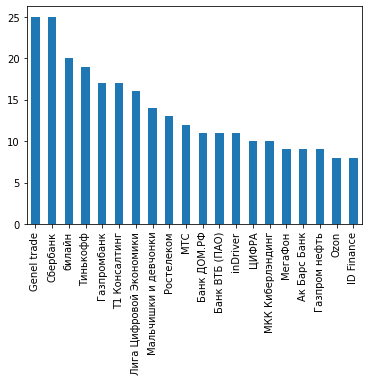

In [18]:
vacancy_df['employer_name'].value_counts().head(20).plot(kind='bar')

<AxesSubplot:>

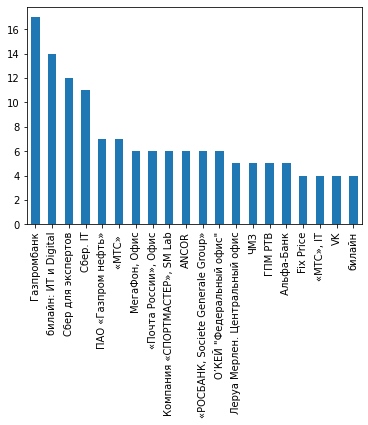

In [19]:
vacancy_df['department_name'].value_counts().head(20).plot(kind='bar')

<AxesSubplot:>

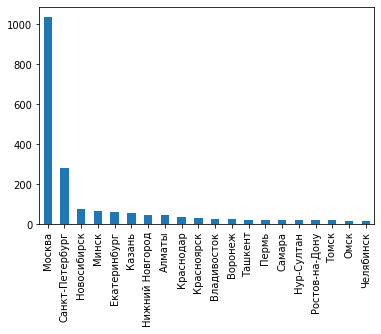

In [20]:
vacancy_df['city'].value_counts().head(20).plot(kind='bar')

### Что с зарплатой?

In [21]:
vacancy_df['salary_from']

0            NaN
1        50000.0
2            NaN
3        40000.0
4            NaN
          ...   
2356         NaN
2357     30000.0
2358    100000.0
2359         NaN
2360    100000.0
Name: salary_from, Length: 2361, dtype: float64

In [22]:
vacancy_df['salary_from'].isna().value_counts(normalize=True)

True     0.697162
False    0.302838
Name: salary_from, dtype: float64

In [23]:
vacancy_df['salary_currency'].value_counts(normalize=True)

RUR    0.916770
KZT    0.037267
USD    0.019876
UZS    0.009938
BYR    0.009938
KGS    0.004969
EUR    0.001242
Name: salary_currency, dtype: float64

In [24]:
salaries = vacancy_df.query("salary_currency == 'RUR' and experience in ['noExperience', 'between1And3']").groupby(['employer_name', 'department_name']).mean()['salary_from'].reset_index()

In [25]:
salaries

,employer_name,department_name,salary_from
0,ANCOR,ANCOR,98000.000000
1,HeadHunter,HeadHunter::Product Management,NaN
2,Альфа-Банк,Альфа-Банк,70000.000000
3,ГЛОРИЯ ДЖИНС,ГЛОРИЯ ДЖИНС. Офис,47800.000000
4,Группа компаний МЕДСИ,ГК Медси. Управляющая компания,NaN
5,"Лента, федеральная розничная сеть","Лента, федеральная розничная сеть, IT",NaN
6,Леруа Мерлен,Леруа Мерлен. Центральный офис,58500.000000
7,МТС,«МТС»,44666.666667
8,Московский Кредитный Банк,Московский Кредитный Банк. Молодые специалисты,37000.000000
9,ОКЕЙ – Федеральная розничная сеть,"О’КЕЙ ""Гипермаркеты""",43600.000000


<AxesSubplot:xlabel='employer_name', ylabel='salary_from'>

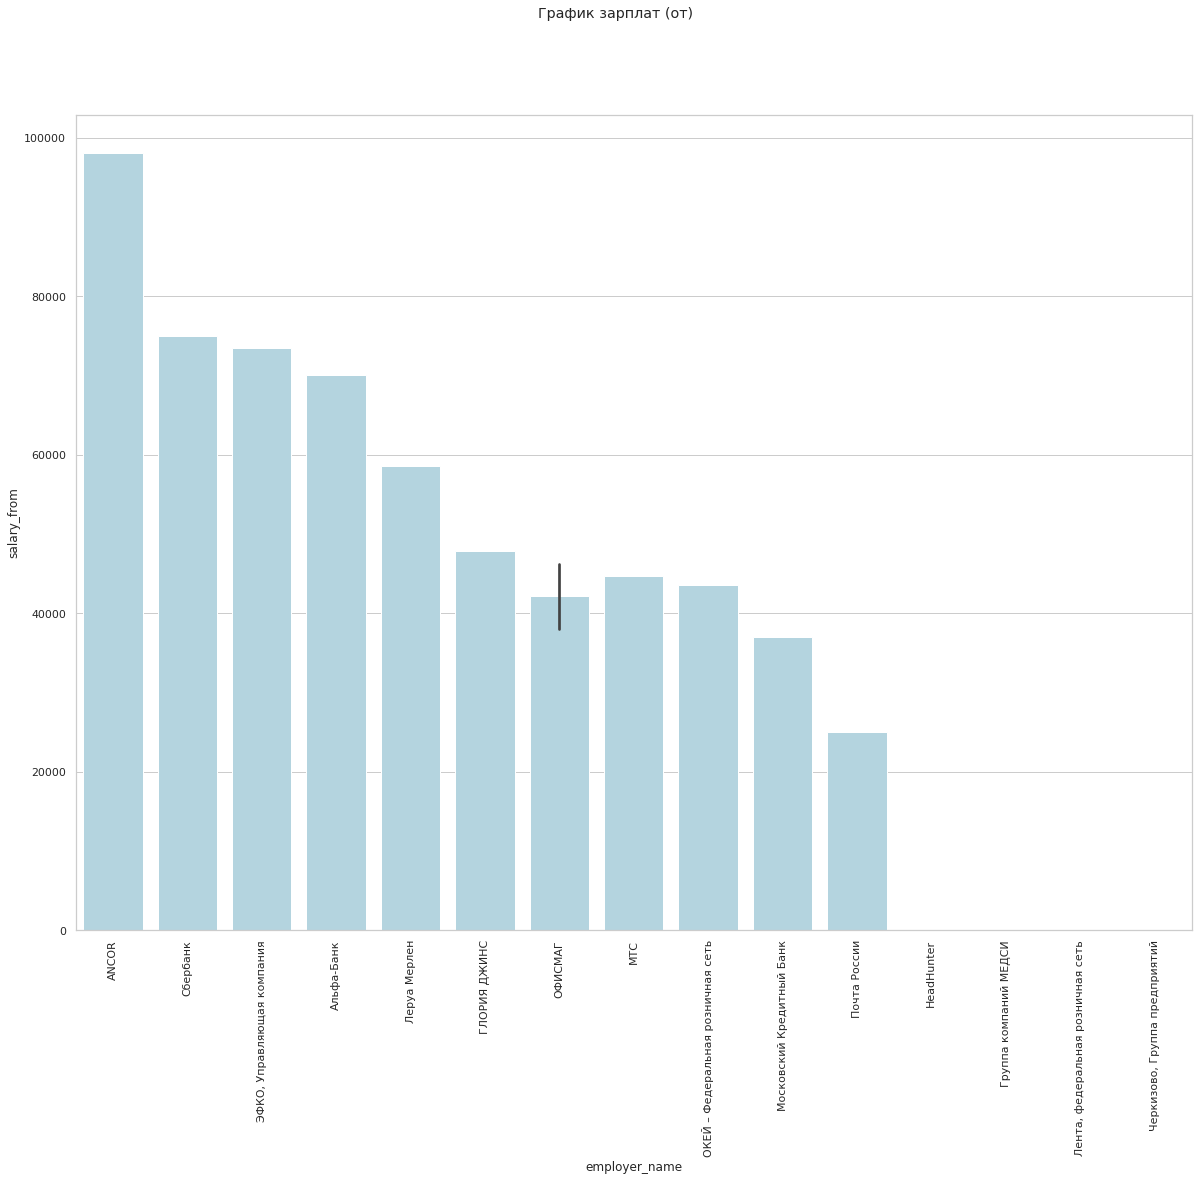

In [26]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)

In [27]:
salaries

,employer_name,department_name,salary_from
0,ANCOR,ANCOR,98000.000000
1,HeadHunter,HeadHunter::Product Management,NaN
2,Альфа-Банк,Альфа-Банк,70000.000000
3,ГЛОРИЯ ДЖИНС,ГЛОРИЯ ДЖИНС. Офис,47800.000000
4,Группа компаний МЕДСИ,ГК Медси. Управляющая компания,NaN
5,"Лента, федеральная розничная сеть","Лента, федеральная розничная сеть, IT",NaN
6,Леруа Мерлен,Леруа Мерлен. Центральный офис,58500.000000
7,МТС,«МТС»,44666.666667
8,Московский Кредитный Банк,Московский Кредитный Банк. Молодые специалисты,37000.000000
9,ОКЕЙ – Федеральная розничная сеть,"О’КЕЙ ""Гипермаркеты""",43600.000000


In [28]:
vacancy_df.dropna(subset=['employer_name', 'salary_from'])[vacancy_df['employer_name'].str.lower().str.contains('альфа')]

/tmp/ipykernel_90/3289431858.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vacancy_df.dropna(subset=['employer_name', 'salary_from'])[vacancy_df['employer_name'].str.lower().str.contains('альфа')]


,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
1610,54517991,False,Бизнес-аналитик (группа BI разработки),None,False,False,"{'id': '88', 'name': 'Казань', 'url': 'https:/...","{'from': 70000, 'to': 70000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Казань', 'street': 'улица Аделя Куту...",None,None,2022-04-01T14:51:09+0300,2022-04-01T14:51:09+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",27,[],[],[],False,between1And3,ГК Альфа,NaN,70000.0,70000.0,True,RUR,Казань
1799,51894005,False,Кредитный аналитик,"{'id': '80-80-bank', 'name': ' Альфа-Банк'}",False,False,"{'id': '54', 'name': 'Красноярск', 'url': 'htt...","{'from': 70000, 'to': 170000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-04T17:59:31+0300,2022-04-04T17:59:31+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",5,[],[],[],False,between1And3,Альфа-Банк,Альфа-Банк,70000.0,170000.0,True,RUR,Красноярск


### Вакансии в Городе Новосибирск

In [29]:
vacancy_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
0,54659098,False,Data Scientist / Data Analyst,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'улица Станиславс...",None,None,2022-04-07T14:56:44+0300,2022-04-07T14:56:44+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",1,[],[],[],False,noExperience,СтандартПроект,NaN,NaN,NaN,NaN,NaN,Москва
1,54615061,False,Machine Learning Engineer (Computer Vision),None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 300000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-06T10:01:57+0300,2022-04-06T10:01:57+0300,False,...,None,"{'id': 'remote', 'name': 'Удаленная работа'}",176,[],[],[],False,noExperience,White & Fluffy,NaN,50000.0,300000.0,False,RUR,Москва
2,54654033,False,Аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'набереж...",None,None,2022-04-07T12:46:11+0300,2022-04-07T12:46:11+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",1,[],[],[],False,noExperience,Национальный исследовательский университет Выс...,NaN,NaN,NaN,NaN,NaN,Санкт-Петербург
3,51476897,False,Аналитик,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 40000, 'to': 40000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Варшавское шоссе...",None,None,2022-04-07T12:04:13+0300,2022-04-07T12:04:13+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",1,[],[],[],False,noExperience,ФБУЗ ФЦГиЭ Роспотребнадзора,NaN,40000.0,40000.0,False,RUR,Москва
4,54320924,False,Data Scientist (аналитик данных в области упра...,None,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Новодмитровская ...",None,None,2022-04-07T13:50:31+0300,2022-04-07T13:50:31+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",476,[],[],[],False,noExperience,ЭКОПСИ Консалтинг,NaN,NaN,NaN,NaN,NaN,Москва
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356,48038307,False,Системный аналитик (Axapta),"{'id': 'okey-1276-fedo', 'name': 'О’КЕЙ ""Федер...",False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'проспек...",None,None,2022-04-04T10:17:48+0300,2022-04-04T10:17:48+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",1,[],[],[],False,between1And3,ОКЕЙ – Федеральная розничная сеть,"О’КЕЙ ""Федеральный офис""",NaN,NaN,NaN,NaN,Санкт-Петербург
2357,48402469,False,Аналитик отдела продаж,None,False,False,"{'id': '49', 'name': 'Киров (Кировская область...","{'from': 30000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-05T09:42:57+0300,2022-04-05T09:42:57+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",0,[],[],[],False,between1And3,Омкирмет-плюс,NaN,30000.0,NaN,False,RUR,Киров (Кировская область)
2358,48488080,False,Аналитик 1С,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 100000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Тайгинская ...",None,None,2022-04-07T08:32:54+0300,2022-04-07T08:32:54+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",0,[],[],[],False,between1And3,СЗ ДСК КПД-Газстрой,NaN,100000.0,NaN,False,RUR,Новосибирск
2359,48601007,False,

In [30]:
city_vacs = vacancy_df[vacancy_df['city'] == "Новосибирск"]

In [31]:
city_vacs['address']

14      {'city': 'Новосибирск', 'street': 'улица Щетин...
34      {'city': None, 'street': None, 'building': Non...
179     {'city': 'Новосибирск', 'street': 'Красный про...
193     {'city': None, 'street': None, 'building': Non...
199     {'city': 'Новосибирск', 'street': 'Центральная...
                              ...                        
2248    {'city': 'Новосибирск', 'street': 'Советская у...
2295                                                 None
2296                                                 None
2358    {'city': 'Новосибирск', 'street': 'Тайгинская ...
2360    {'city': 'Новосибирск', 'street': 'улица Мира'...
Name: address, Length: 75, dtype: object

In [32]:
city_vacs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 14 to 2360
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        75 non-null     object 
 1   premium                   75 non-null     bool   
 2   name                      75 non-null     object 
 3   department                7 non-null      object 
 4   has_test                  75 non-null     bool   
 5   response_letter_required  75 non-null     bool   
 6   area                      75 non-null     object 
 7   salary                    35 non-null     object 
 8   type                      75 non-null     object 
 9   address                   48 non-null     object 
 10  response_url              0 non-null      object 
 11  sort_point_distance       0 non-null      object 
 12  published_at              75 non-null     object 
 13  created_at                75 non-null     object 
 14  archived 

In [33]:
city_vacs.head(10)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
14,52819002,False,Data Analyst (Marketing),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Щетин...",None,None,2022-04-07T12:45:52+0300,2022-04-07T12:45:52+0300,False,...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",57,[],[],[],False,noExperience,Dankolab,NaN,NaN,NaN,NaN,NaN,Новосибирск
34,54478211,False,Маркетолог-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",None,None,2022-04-06T09:50:59+0300,2022-04-06T09:50:59+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",10,[],[],[],False,noExperience,ГАРС,NaN,NaN,NaN,NaN,NaN,Новосибирск
179,49295550,False,Инженер-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': None, 'to': 50000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Красный про...",None,None,2022-04-01T16:47:54+0300,2022-04-01T16:47:54+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",10,[],[],[],False,noExperience,"КРИСТА, НПО",NaN,NaN,50000.0,True,RUR,Новосибирск
193,52449389,False,Младший аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 35000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",None,None,2022-04-07T07:23:04+0300,2022-04-07T07:23:04+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",101,[],[],[],False,noExperience,Информационные системы и сервисы,NaN,35000.0,NaN,True,RUR,Новосибирск
199,54151995,False,Провизор-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 55000, 'to': 75000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Центральная...",None,None,2022-04-05T13:17:32+0300,2022-04-05T13:17:32+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",3,[],[],[],False,noExperience,Сибирская Аптека,NaN,55000.0,75000.0,False,RUR,Новосибирск
200,54151995,False,Провизор-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 55000, 'to': 75000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Центральная...",None,None,2022-04-05T13:17:32+0300,2022-04-05T13:17:32+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",3,[],[],[],False,noExperience,Сибирская Аптека,NaN,55000.0,75000.0,False,RUR,Новосибирск
202,54452020,False,Бизнес-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 45000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",None,None,2022-04-05T11:29:18+0300,2022-04-05T11:29:18+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",28,[],[],[],False,noExperience,Информационные системы и сервисы,NaN,45000.0,NaN,True,RUR,Новосибирск
207,54510100,False,Системный аналитик,"{'id': 'mts-3776-it', 'name': '«МТС», IT'}",False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-01T11:28:06+0300,2022-04-01T11:28:06+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",15,[],[],[],False,noExperience,МТС,"«МТС», IT",NaN,NaN,NaN,NaN,Новосибирск
230,46873002,False,Стажер аналитик-проектировщик,None,True,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 30000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name

### Посмотрим содержание вакансий

In [34]:
vacs_df = city_vacs.copy().reset_index(drop=True).query("experience in ['noExperience', 'between1And3']")

In [35]:
vacs_df

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city
0,52819002,False,Data Analyst (Marketing),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'улица Щетин...",None,None,2022-04-07T12:45:52+0300,2022-04-07T12:45:52+0300,False,...,None,"{'id': 'flexible', 'name': 'Гибкий график'}",57,[],[],[],False,noExperience,Dankolab,NaN,NaN,NaN,NaN,NaN,Новосибирск
1,54478211,False,Маркетолог-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",None,None,2022-04-06T09:50:59+0300,2022-04-06T09:50:59+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",10,[],[],[],False,noExperience,ГАРС,NaN,NaN,NaN,NaN,NaN,Новосибирск
2,49295550,False,Инженер-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': None, 'to': 50000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Красный про...",None,None,2022-04-01T16:47:54+0300,2022-04-01T16:47:54+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",10,[],[],[],False,noExperience,"КРИСТА, НПО",NaN,NaN,50000.0,True,RUR,Новосибирск
3,52449389,False,Младший аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 35000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",None,None,2022-04-07T07:23:04+0300,2022-04-07T07:23:04+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",101,[],[],[],False,noExperience,Информационные системы и сервисы,NaN,35000.0,NaN,True,RUR,Новосибирск
4,54151995,False,Провизор-аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 55000, 'to': 75000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Центральная...",None,None,2022-04-05T13:17:32+0300,2022-04-05T13:17:32+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",3,[],[],[],False,noExperience,Сибирская Аптека,NaN,55000.0,75000.0,False,RUR,Новосибирск
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,54641749,False,Data аналитик,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Советская у...",None,None,2022-04-07T07:35:20+0300,2022-04-07T07:35:20+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",5,[],[],[],False,between1And3,АйтиСмартФинанс,NaN,NaN,NaN,NaN,NaN,Новосибирск
71,53829320,False,Бизнес аналитик/Системный аналитик(IT),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-04T16:41:59+0300,2022-04-04T16:41:59+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",19,[],[],[],False,between1And3,Юсмп Групп,NaN,NaN,NaN,NaN,NaN,Новосибирск
72,54129260,False,Бизнес аналитик/Системный аналитик (IT),None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...",None,"{'id': 'open', 'name': 'Открытая'}",None,None,None,2022-04-05T07:11:14+0300,2022-04-05T07:11:14+0300,False,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",22,[],[],[],False,between1And3,Юсмп Групп,NaN,NaN,NaN,NaN,NaN,Новосибирск
73,48488080,False,Аналитик 1С,None,False,False,"{'id': '4', 'name': 'Новосибирск', 'url': 'htt...","{'from': 100000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Новосибирск', 'street': 'Тайгинская ...",None,None,202

In [36]:
vacs_df['url']

0     https://api.hh.ru/vacancies/52819002?host=hh.ru
1     https://api.hh.ru/vacancies/54478211?host=hh.ru
2     https://api.hh.ru/vacancies/49295550?host=hh.ru
3     https://api.hh.ru/vacancies/52449389?host=hh.ru
4     https://api.hh.ru/vacancies/54151995?host=hh.ru
                           ...                       
70    https://api.hh.ru/vacancies/54641749?host=hh.ru
71    https://api.hh.ru/vacancies/53829320?host=hh.ru
72    https://api.hh.ru/vacancies/54129260?host=hh.ru
73    https://api.hh.ru/vacancies/48488080?host=hh.ru
74    https://api.hh.ru/vacancies/48629323?host=hh.ru
Name: url, Length: 75, dtype: object

Делю вакансии на котегории в Новосибирске

In [37]:
# Создаю пустой дата фрейм
columns_vacs_df=vacs_df.columns
df_video_data= pd.DataFrame(columns=columns_vacs_df)
#df_video_data.info()
#df_video_data

Смотрим по новосибирску

In [38]:
df_invest_data= pd.DataFrame(columns=columns_vacs_df)


In [39]:
url_vacs=vacs_df['url'][1]
vacs = json.loads(requests.get(url_vacs).text)['description']
vacs=vacs.lower()

## Рассмотрю для Новосибирска

In [40]:
# Создаю таблицы для копирования
columns_vacs_df=vacs_df.columns
df_invest_data_city= pd.DataFrame(columns=columns_vacs_df)
df_sport_data_city= pd.DataFrame(columns=columns_vacs_df)
df_video_data_city= pd.DataFrame(columns=columns_vacs_df)
df_distrib_data_city= pd.DataFrame(columns=columns_vacs_df)
df_marketing_data_city= pd.DataFrame(columns=columns_vacs_df)

df_others_city= pd.DataFrame(columns=columns_vacs_df)


# создаю индексы по котегории ванаксий
nomber_vacs_city=0
df_max=vacs_df['url'].count()

df_invest_count=0
df_invest=['инвестиции','инвестиций','акции','вложени','портфель','банк ',' банк']

df_sport_count=0
df_sport=['матч','трансляц']

df_video_count=0
df_video=['видео','изображен','зрени']

df_distrib_count=0
df_distrib=['ассортиме','полк']

df_marketing_count=0
df_marketing=['маркетинговое агенст','маркетинговая компан','digital агентств']


df_others_count=0

for index_vacs in range(1,df_max):
    url_vacs=vacs_df['url'][index_vacs]
    vacs = json.loads(requests.get(url_vacs).text)['description']
    vacs=vacs.lower()
    check=0 # Что бы одни и те же вакансии не выводились
    if 'python' in vacs:
         ############             Маркетинг
        #check==0
        for value in df_marketing:
            if check==0:
                if value in vacs:
                    df_marketing_count+=1
                    check=1
                    df_marketing_data_city = df_marketing_data_city.append(vacs_df.iloc[index_vacs], ignore_index=True)
                    #print('Добавили вакансию df_distrib')
                    #print(vacs,index_vacs)
                    #print('===========
        for value in df_invest:
            if check==0:
                if value in vacs:
                    df_invest_count+=1
                    df_invest_data_city = df_invest_data_city.append(vacs_df.iloc[index_vacs], ignore_index=True)
                    #print('Добавили вакансию df_invest', vacs_df.iloc[index_vacs]['id'])
                    #display(df_invest_data)
                    #print(vacs,index_vacs)
                    #print('===========================================================================================')
                    check=1
        #check==0            
        for value in df_sport:
            if check==0:
                if value in vacs:
                    df_sport_count+=1
                    check=1
                    df_sport_data_city = df_sport_data_city.append(vacs_df.iloc[index_vacs], ignore_index=True)
                    #print('Добавили вакансию df_sport')
                    #print(vacs,index_vacs)
                    #print('===========================================================================================')
        #check==0            
        for value in df_video:
            if check==0:
                if value in vacs:
                    df_video_count+=1   
                    check=1


                    df_video_data_city = df_video_data_city.append(vacs_df.iloc[index_vacs], ignore_index=True)
                    #print('Добавили вакансию df_video')
                    #print(vacs,index_vacs)
                    #print('===========================================================================================')
        #check==0
        for value in df_distrib:
            if check==0:
                if value in vacs:
                    df_distrib_count+=1
                    check=1
                    df_distrib_data_city = df_distrib_data_city.append(vacs_df.iloc[index_vacs], ignore_index=True)
                    #print('Добавили вакансию df_distrib')
                    #print(vacs,index_vacs)
                    #print('===========================================================================================')
       #================================================================================')            
        if check==0:
            df_others_city = df_others_city.append(vacs_df.iloc[index_vacs], ignore_index=True)
            df_others_count+=1 

#Формирую таблицу
df_interes_vacanci333333 = {"data": [1,2,3,4,5,6], "ctigoriy_vacanc": ['invest', 'sport', 'video','distrib','marketing','others'], "Nombers": [df_invest_count, df_sport_count,df_video_count, df_distrib_count,df_marketing_count,df_others_count]}

df_interes_vacanci = pd.DataFrame(df_interes_vacanci333333)
df_interes_vacanci

#sns.set(style='whitegrid')
#fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
#title = 'График зарплат (от)'
#fig.suptitle(title)
#plt.xticks(rotation=90)  
##sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)
#sns.barplot(data=df_interes_vacanci, x='ctigoriy_vacanc', y='Nombers', color='lightblue', ax=ax)

#display(df_video_data)
#df_video_data.info()


,data,ctigoriy_vacanc,Nombers
0,1,invest,1
1,2,sport,0
2,3,video,1
3,4,distrib,0
4,5,marketing,0
5,6,others,5


In [41]:
df_marketing_data_city

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,response_url,sort_point_distance,published_at,created_at,archived,...,contacts,schedule,counters,working_days,working_time_intervals,working_time_modes,accept_temporary,experience,employer_name,department_name,salary_from,salary_to,salary_gross,salary_currency,city


<AxesSubplot:xlabel='ctigoriy_vacanc', ylabel='Nombers'>

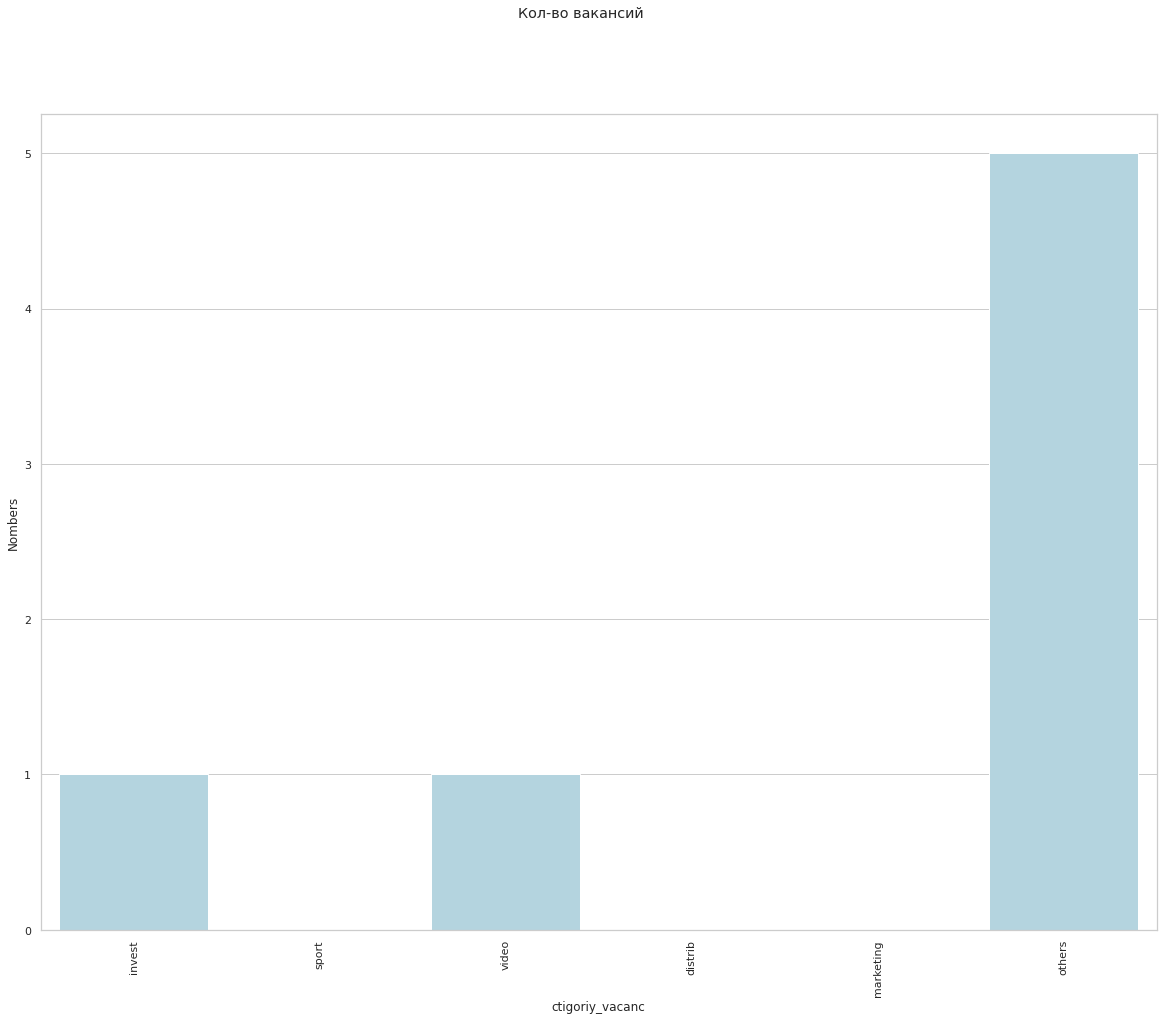

In [42]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'Кол-во вакансий'
fig.suptitle(title)
plt.xticks(rotation=90)  
#sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)
sns.barplot(data=df_interes_vacanci, x='ctigoriy_vacanc', y='Nombers', color='lightblue', ax=ax) #salary_from


Обьеденю таблицы т.е добвлю строчки и фиксирую из какой таблицы были взяты данные

In [43]:
df_video_data_city['catigoriy']='video'
df_invest_data_city['catigoriy']='invest'
df_sport_data_city['catigoriy']='sport'
df_distrib_data_city['catigoriy']='distrib'
df_marketing_data_city['catigoriy']='marketing'
df_others_city['catigoriy']='others'

In [44]:
df_citi_zarplata=df_video_data_city

In [45]:
df_citi_zarplata=df_citi_zarplata.append(df_invest_data_city,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_sport_data_city,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_distrib_data_city,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_marketing_data_city,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_others_city,ignore_index=True)

<AxesSubplot:xlabel='catigoriy', ylabel='salary_from'>

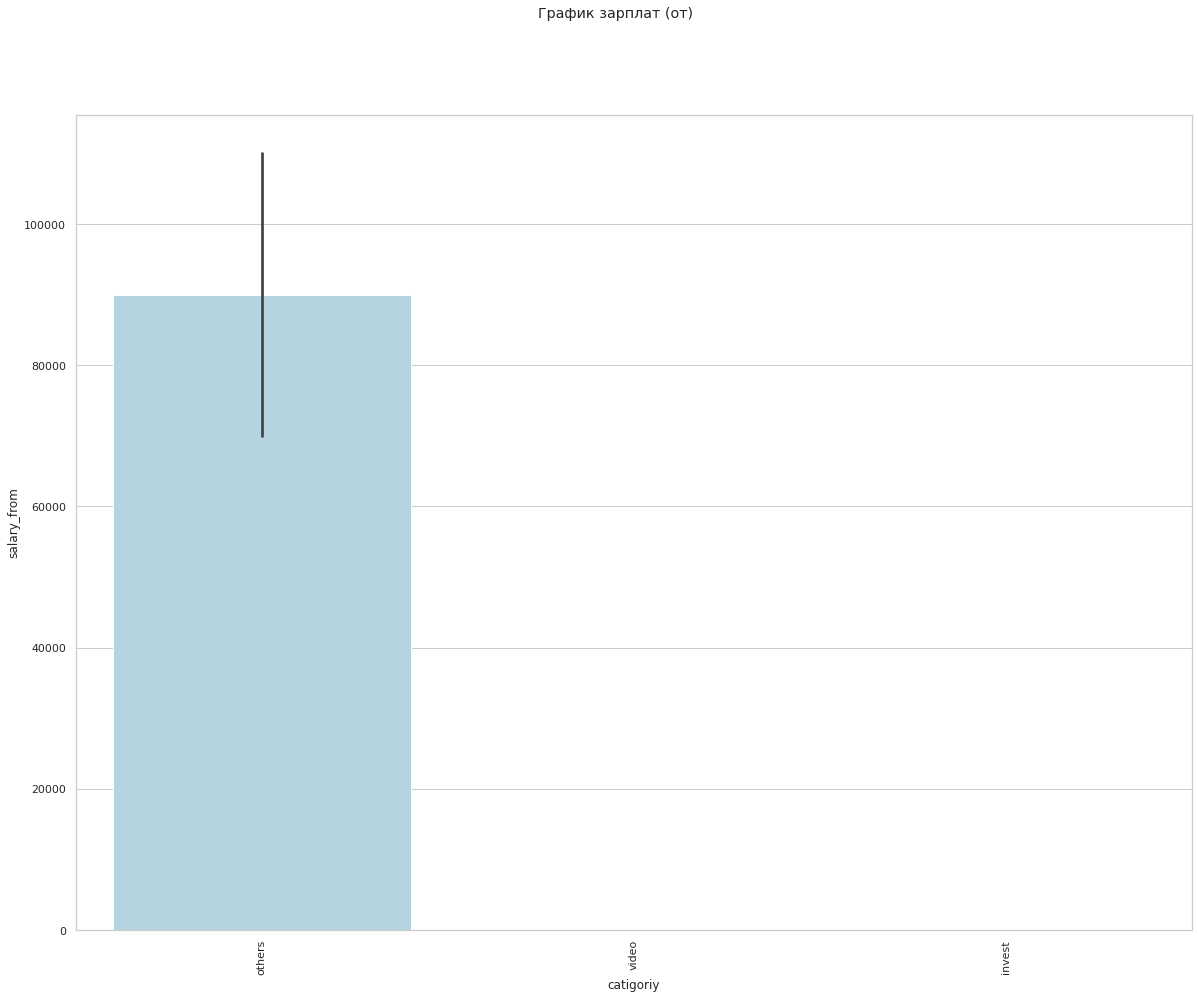

In [46]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=df_citi_zarplata.sort_values(by='salary_from', ascending=False), x='catigoriy', y='salary_from'
            , color='lightblue'
            #, ax=axdf_citi_zarplata
           )

### Для просмотра ваканский из нужной категории нужно раскоментировать

Сгенерировал специально ошибку, что бы остановить работу программы и посмотреть результаты

In [47]:
ва

NameError: name 'ва' is not defined

In [48]:
#vacs_df_city=df_marketing_data_city
#vacs_df_city=df_video_data_city
#vacs_df_city=df_invest_data_city
#vacs_df_city=df_sport_data_city
#vacs_df_city=df_distrib_data_city
vacs_df_city=df_others_city

In [49]:
button = widgets.Button(description="show")
output = widgets.Output()

display(button, output)

counter = 0
def on_clicked(b):
    with output: 
        try:
            global counter
            clear_output()
            print('№ вакансии: ', counter)
            display(HTML("<h1>" + str(vacs_df_city['name'][counter]) + ' в ' + str(vacs_df_city['employer_name'][counter]) + "</h1>"))
            display(vacs[counter])
            display(HTML('<a href="' + str(vacs_df_city['alternate_url'][counter]) + '" target="_blank">Ссылка на вакансию</a>'))
            counter += 1
        except Exception as e:
            print('Вакансии закончились')
            
button.on_click(on_clicked)

Button(description='show', style=ButtonStyle())

Output()

## Рассматриваю вакансии для всех городов с удаленкой

In [50]:
columns_vacs_df=vacs_df.columns
df_invest_data= pd.DataFrame(columns=columns_vacs_df)
df_sport_data= pd.DataFrame(columns=columns_vacs_df)
df_video_data= pd.DataFrame(columns=columns_vacs_df)
df_distrib_data= pd.DataFrame(columns=columns_vacs_df)
df_marketing_data= pd.DataFrame(columns=columns_vacs_df)
df_others_data= pd.DataFrame(columns=columns_vacs_df)
df_error= pd.DataFrame(columns=columns_vacs_df)


vacs_df_all_city = vacancy_df.copy().reset_index(drop=True).query("experience in ['noExperience', 'between1And3']")
nomber_vacs_city=0
df_max=vacs_df_all_city['url'].count()

df_invest_count=0
df_invest=['инвестиции','инвестиций','акции','вложени','портфель','банк ',' банк']

df_sport_count=0
df_sport=['матч','трансляц']

df_video_count=0
df_video=['видео','изображен','зрени']

df_distrib_count=0
df_distrib=['ассортиме','полка','полку']

df_marketing_count=0
df_marketing=['маркетинговое агенст','маркетинговая компан','digital агентств']

df_others_count=0

df_error_count=0
sdf=0

nomber_error=0# Для отслеживания ошибки

for index_vacs in range(1,df_max):
#for index_vacs in range(1,500):  # Отладка
    url_vacs=vacs_df_all_city['url'][index_vacs]
    vacs = json.loads(requests.get(url_vacs).text)['description']
    vacs=vacs.lower()
    #print(index_vacs)
    check=0 # Что бы одни и те же вакансии не выводились
    nomber_error=0
    if ' python' in vacs:
        if ' удалённ' or ' удален' in vacs:
            print('Нашлась удаленая вакансия в строчке=',index_vacs)
            try:
                ############             Маркетинг
                #check==0
                for value in df_marketing:
                    if check==0:
                        nomber_error=1    
                        if value in vacs:
                            df_marketing_count+=1
                            check=1
                            nomber_error=2
                            df_marketing_data = df_marketing_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                            print('Маркетинг')
                            #print(vacs,index_vacs)
                            #print('=================

                for value in df_invest:
                    if check==0:
                        nomber_error=3
                        if value in vacs:
                            df_invest_count+=1
                            #df_invest_data = df_invest_data.append(vacs_df.iloc[index_vacs],ignore_index=True)
                            df_invest_data = df_invest_data.append(vacs_df_all_city.iloc[index_vacs],ignore_index=True)
                            print("df_invest_data-Записалось")
                            check=1
                            nomber_error=4
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')

                            check=1
                #check==0            
                for value in df_sport:
                    if check==0:
                        nomber_error=5
                        if value in vacs:
                            df_sport_count+=1
                            check=1
                            nomber_error=6
                            #df_sport_data = df_sport_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                            df_sport_data = df_sport_data.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                            print("df_sport_data-Записалось")
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')
               # check==0            
                for value in df_video:
                    if check==0:
                        nomber_error=7
                        if value in vacs:
                            df_video_count+=1   
                            check=1
                            nomber_error=8
                            #df_video_data = df_video_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                            df_video_data = df_video_data.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                            print("df_video_data-Записалось")
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')
                #check==0
                for value in df_distrib:
                    if check==0:
                        nomber_error=9
                        if value in vacs:
                            df_distrib_count+=1
                            check=1
                            nomber_error=10
                            #df_distrib_data = df_distrib_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                            df_distrib_data = df_distrib_data.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                            print("df_distrib-Записалось")
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')
                #==========================================================================')   
                if check==0:
                    df_others_data = df_others_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                    df_others_count+=1 
                    check=1
            except:
                df_error=df_error.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                df_error_count+=1
                print(nomber_error)
                print('Значение value',value)
                print('Значение vacs',vacs)
                print('Произошла ошибка в строчке=',index_vacs)
            

#Формирую таблицу
df_interes_vacanci333333 = {"data": [1,2,3,4,5,6,7], "ctigoriy_vacanc": ['invest', 'sport', 'video','distrib','marketing','others','error'], "Nombers": [df_invest_count, df_sport_count,df_video_count, df_distrib_count,df_marketing_count,df_others_count,df_error_count]}

df_interes_vacanci = pd.DataFrame(df_interes_vacanci333333)
df_interes_vacanci

#sns.set(style='whitegrid')
#fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
#title = 'График зарплат (от)'
#fig.suptitle(title)
#plt.xticks(rotation=90)  
##sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)
#sns.barplot(data=df_interes_vacanci, x='ctigoriy_vacanc', y='Nombers', color='lightblue', ax=ax)


Нашлась удаленая вакансия в строчке= 2
Нашлась удаленая вакансия в строчке= 9
Нашлась удаленая вакансия в строчке= 10
Нашлась удаленая вакансия в строчке= 11
Нашлась удаленая вакансия в строчке= 14
Нашлась удаленая вакансия в строчке= 20
df_invest_data-Записалось
Нашлась удаленая вакансия в строчке= 22
Нашлась удаленая вакансия в строчке= 25
Нашлась удаленая вакансия в строчке= 36
Нашлась удаленая вакансия в строчке= 39
Нашлась удаленая вакансия в строчке= 43
Нашлась удаленая вакансия в строчке= 55
Нашлась удаленая вакансия в строчке= 60
df_video_data-Записалось
Нашлась удаленая вакансия в строчке= 66
Нашлась удаленая вакансия в строчке= 67
df_invest_data-Записалось
Нашлась удаленая вакансия в строчке= 79
df_distrib-Записалось
Нашлась удаленая вакансия в строчке= 102
9
Значение value полку
Значение vacs <p><em>научный сотрудник в исследовательскую группу лаборатории &quot;компьютерное моделирование природных и социальных систем” национального центра когнитивных разработок (на базе унив

,data,ctigoriy_vacanc,Nombers
0,1,invest,51
1,2,sport,6
2,3,video,43
3,4,distrib,3
4,5,marketing,0
5,6,others,12
6,7,error,229


In [51]:
# Интересные вакансии
df_interes_vacanci

,data,ctigoriy_vacanc,Nombers
0,1,invest,51
1,2,sport,6
2,3,video,43
3,4,distrib,3
4,5,marketing,0
5,6,others,12
6,7,error,229


<AxesSubplot:xlabel='ctigoriy_vacanc', ylabel='Nombers'>

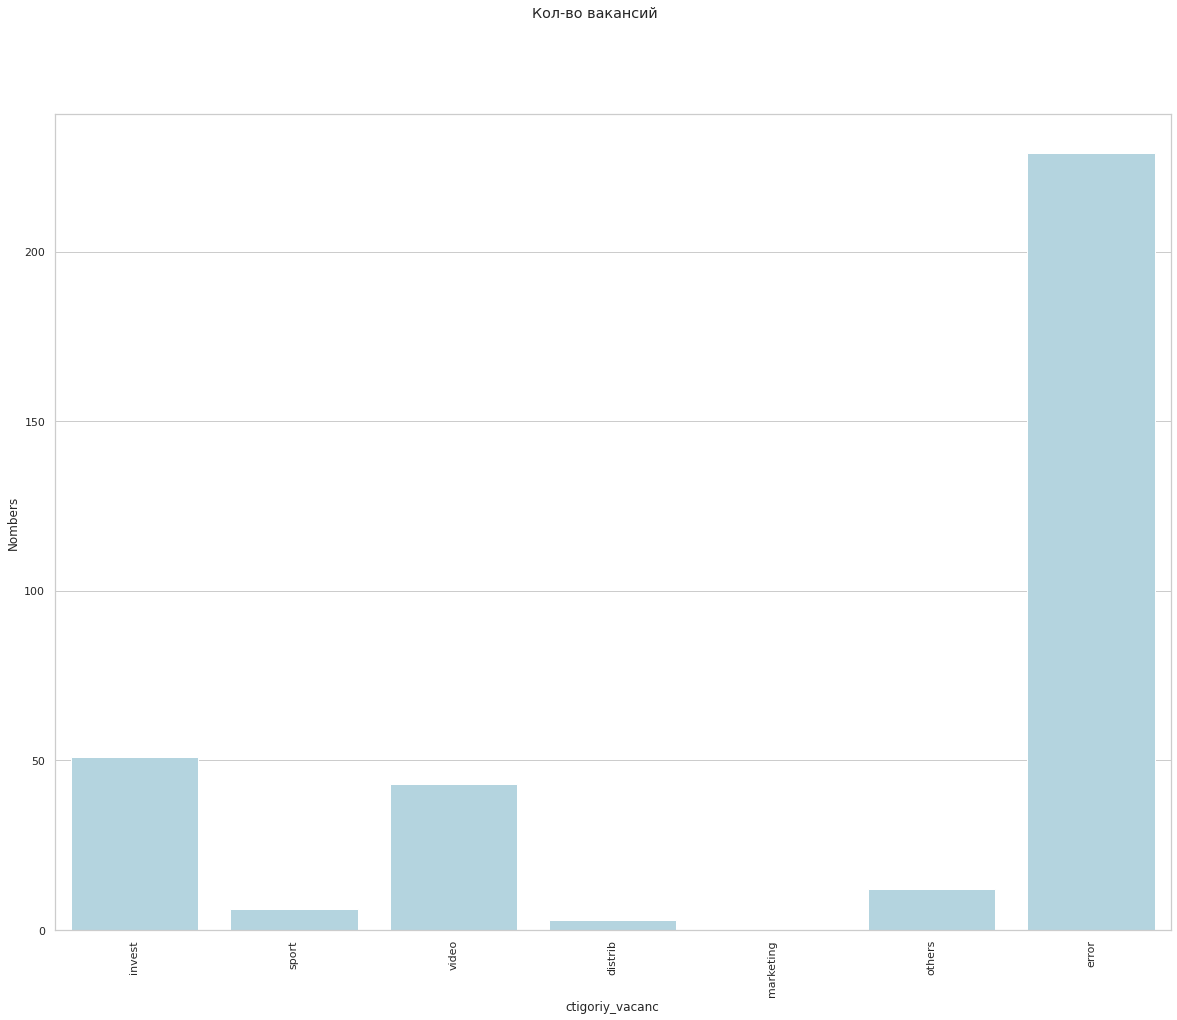

In [53]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'Кол-во вакансий'
fig.suptitle(title)
plt.xticks(rotation=90)  
#sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)
sns.barplot(data=df_interes_vacanci, x='ctigoriy_vacanc', y='Nombers', color='lightblue', ax=ax) #salary_from

Посмотрю на зарплаты 

<AxesSubplot:xlabel='catigoriy', ylabel='salary_from'>

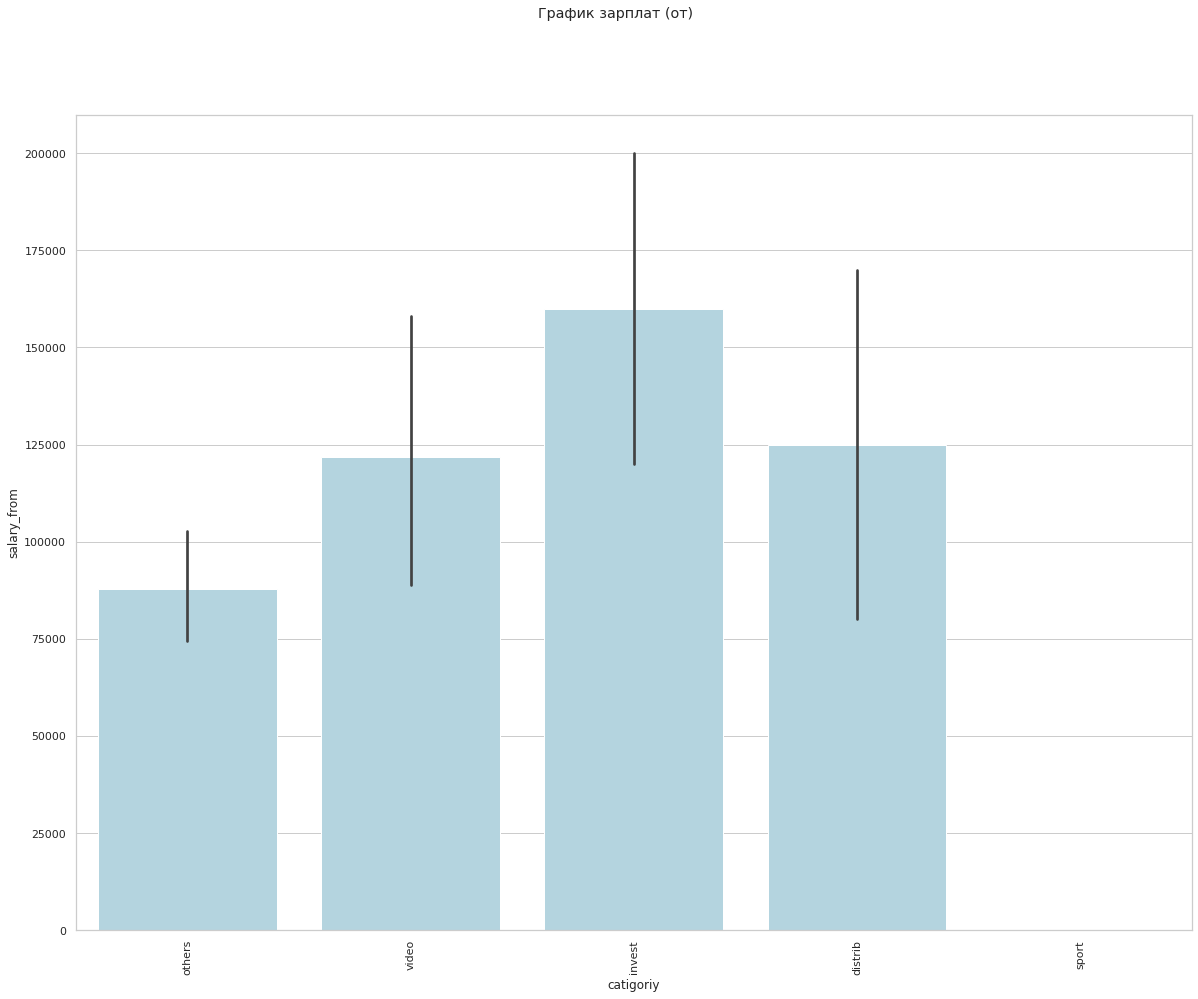

In [54]:
df_video_data['catigoriy']='video'
df_invest_data['catigoriy']='invest'
df_sport_data['catigoriy']='sport'
df_distrib_data['catigoriy']='distrib'

df_marketing_data['catigoriy']='marketing'
df_others_data['catigoriy']='others'
df_error['catigoriy']='others'
df_citi_zarplata=df_video_data




df_citi_zarplata=df_citi_zarplata.append(df_invest_data,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_sport_data,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_distrib_data,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_marketing_data,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_others_data,ignore_index=True)
df_citi_zarplata=df_citi_zarplata.append(df_error,ignore_index=True)
#df_marketing_data_city= pd.DataFrame(columns=columns_vacs_df)

sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=df_citi_zarplata.sort_values(by='salary_from', ascending=False), x='catigoriy', y='salary_from'
            , color='lightblue'
            #, ax=axdf_citi_zarplata
           )

df_video_data
df_invest_data
df_sport_data
df_distrib_data
df_marketing_data

### Вакансии с удаленной работой, для просмотра вакансий с нужной категорией нужно раскоментировать 

In [55]:
vacs_df=df_interes_vacanci

In [56]:
# нужно раскоментировать нужную категорию
#vacs_df=df_video_data
vacs_df=df_invest_data
#vacs_df=df_sport_data
#vacs_df=df_distrib_data
#vacs_df=df_marketing_data
#vacs_df=df_others_data
#vacs_df=df_error

In [57]:
button = widgets.Button(description="show")
output = widgets.Output()

display(button, output)

counter = 0
def on_clicked(b):
    with output: 
        try:
            global counter
            clear_output()
            print('№ вакансии: ', counter)
            display(HTML("<h1>" + str(vacs_df['name'][counter]) + ' в ' + str(vacs_df['employer_name'][counter]) + "</h1>"))
            display(vacs[counter])
            display(HTML('<a href="' + str(vacs_df['alternate_url'][counter]) + '" target="_blank">Ссылка на вакансию</a>'))
            counter += 1
        except Exception as e:
            print('Вакансии закончились')
            
button.on_click(on_clicked)

Button(description='show', style=ButtonStyle())

Output()

## Расмотрю все варианты без удаленой работы для всех горов

In [ ]:
columns_vacs_df=vacs_df.columns
df_invest_data1= pd.DataFrame(columns=columns_vacs_df)
df_sport_data1= pd.DataFrame(columns=columns_vacs_df)
df_video_data1= pd.DataFrame(columns=columns_vacs_df)
df_distrib_data1= pd.DataFrame(columns=columns_vacs_df)
df_marketing_data1= pd.DataFrame(columns=columns_vacs_df)

vacs_df_all_city = vacancy_df.copy().reset_index(drop=True).query("experience in ['noExperience', 'between1And3']")
nomber_vacs_city=0
df_max=vacs_df_all_city['url'].count()

df_invest_count=0
df_invest=['инвестиции','инвестиций','акции','вложени','портфель','маркетинговое агенст']

df_sport_count=0
df_sport=['матч','трансляц']

df_video_count=0
df_video=['видео','изображен','зрени']

df_distrib_count=0
df_distrib=['ассортиме','полка','полку']

df_marketing_count=0
df_marketing=['маркетинговое агенст','маркетинговая компан','digital агентств','маркетинговые кампани']

sdf=0

for index_vacs in range(1,df_max):
#for index_vacs in range(1,500):  # Отладка
    url_vacs=vacs_df_all_city['url'][index_vacs]
    vacs = json.loads(requests.get(url_vacs).text)['description']
    vacs=vacs.lower()
    #print(index_vacs)
    check=0 # Что бы одни и те же вакансии не выводились
    if ' python' in vacs:
        
       
        try:
            check==0
            for value in df_marketing:
                if check==0:
                    if value in vacs:
                        df_distrib_count+=1
                        check=1
                            #df_distrib_data = df_distrib_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                        df_marketing_data1 = df_marketing_data1.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                        print("Маркетинг-Записалось")
            check==0              

            for value in df_invest:
                if check==0:
                    if value in vacs:
                        df_invest_count+=1
                            #df_invest_data = df_invest_data.append(vacs_df.iloc[index_vacs],ignore_index=True)
                        df_invest_data1 = df_invest_data1.append(vacs_df_all_city.iloc[index_vacs],ignore_index=True)
                        print("df_invest_data-Записалось")
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')

                        check=1
            check==0            
            for value in df_sport:
                if check==0:
                    if value in vacs:
                        df_sport_count+=1
                        check=1
                            #df_sport_data = df_sport_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                        df_sport_data1 = df_sport_data1.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                        print("df_sport_data-Записалось")
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')
            check==0            
            for value in df_video:
                if check==0:
                    if value in vacs:
                        df_video_count+=1   
                        check=1
                            #df_video_data = df_video_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                        df_video_data1 = df_video_data1.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                        print("df_video_data-Записалось")
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')
            check==0
            for value in df_distrib:
                if check==0:
                    if value in vacs:
                        df_distrib_count+=1
                        check=1
                            #df_distrib_data = df_distrib_data.append(vacs_df.iloc[index_vacs], ignore_index=True)
                        df_distrib_data1 = df_distrib_data1.append(vacs_df_all_city.iloc[index_vacs], ignore_index=True)
                        print("df_distrib-Записалось")
                            #print(vacs,index_vacs)
                            #print('===========================================================================================')
            ######################
            
        except:
            sdf+=1
            print('Произошла ошибка в строчке=',index_vacs)

#Формирую таблицу
df_interes_vacanci333333 = {"data": [1,2,3,4,5], "ctigoriy_vacanc": ['invest', 'sport', 'video','distrib','marketing'], "Nombers": [df_invest_count, df_sport_count,df_video_count, df_distrib_count,df_marketing_count]}

df_interes_vacanci = pd.DataFrame(df_interes_vacanci333333)
df_interes_vacanci


In [ ]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'Кол-во вакансий'
fig.suptitle(title)
plt.xticks(rotation=90)  
#sns.barplot(data=salaries.sort_values(by='salary_from', ascending=False), x='employer_name', y='salary_from', color='lightblue', ax=ax)
sns.barplot(data=df_interes_vacanci, x='ctigoriy_vacanc', y='Nombers', color='lightblue', ax=ax) #salary_from

In [ ]:
df_video_data1['catigoriy']='video'
df_invest_data1['catigoriy']='invest'
df_sport_data1['catigoriy']='sport'
df_distrib_data1['catigoriy']='distrib'
df_marketing_data1['catigoriy']='marketing'



df_citi_zarplata1=df_video_data1
df_citi_zarplata1=df_citi_zarplata1.append(df_invest_data1,ignore_index=True)
df_citi_zarplata1=df_citi_zarplata1.append(df_sport_data1,ignore_index=True)
df_citi_zarplata1=df_citi_zarplata1.append(df_distrib_data1,ignore_index=True)
df_citi_zarplata1=df_citi_zarplata1.append(df_marketing_data1,ignore_index=True)
sns.set(style='whitegrid')
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(20,15))                
title = 'График зарплат (от)'
fig.suptitle(title)
plt.xticks(rotation=90)  
sns.barplot(data=df_citi_zarplata1.sort_values(by='salary_from', ascending=False), x='catigoriy', y='salary_from'
            , color='lightblue'
            #, ax=axdf_citi_zarplata
           )

df_invest_data1= pd.DataFrame(columns=columns_vacs_df)
df_sport_data1= pd.DataFrame(columns=columns_vacs_df)
df_video_data1= pd.DataFrame(columns=columns_vacs_df)
df_distrib_data1= pd.DataFrame(columns=columns_vacs_df)

для просмотра вакансий с нужной категорией нужно раскоментировать¶

In [ ]:
vacs_df=df_invest_data1
#vacs_df=df_sport_data1
#vacs_df=df_distrib_data1
#vacs_df=df_marketing_data1
#vacs_df=df_video_data1

In [ ]:

button = widgets.Button(description="show")
output = widgets.Output()

display(button, output)

counter = 0
def on_clicked(b):
    with output: 
        try:
            global counter
            clear_output()
            print('№ вакансии: ', counter)
            display(HTML("<h1>" + str(vacs_df['name'][counter]) + ' в ' + str(vacs_df['employer_name'][counter]) + "</h1>"))
            display(vacs[counter])
            display(HTML('<a href="' + str(vacs_df['alternate_url'][counter]) + '" target="_blank">Ссылка на вакансию</a>'))
            counter += 1
        except Exception as e:
            print('Вакансии закончились')
            
button.on_click(on_clicked)